In [61]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import random

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

In [62]:
df = pd.read_csv('BTC-USD.csv')

In [63]:
df.head()

,Time,Low,High,Open,Close,Volume
0,1528968660,6489.549805,6489.560059,6489.560059,6489.549805,0.587100
1,1528968720,6487.370117,6489.560059,6489.549805,6487.379883,7.706374
2,1528968780,6479.410156,6487.370117,6487.370117,6479.410156,3.088252
3,1528968840,6479.410156,6479.419922,6479.419922,6479.410156,1.404100
4,1528968900,6475.930176,6479.979980,6479.410156,6479.979980,0.753000


In [64]:
def classify(future, present):
    return 1 if float(future) > float(present) else 0

In [66]:
SEQ_LEN = 30

df = df.loc[:, ['Close']]

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97724 entries, 0 to 97723
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   97724 non-null  float64
dtypes: float64(1)
memory usage: 763.6 KB


In [68]:
df.isnull().sum()

Close    0
dtype: int64

In [69]:
remainder = df.index[-(len(df) % SEQ_LEN)]
df = df.loc[df.index < remainder, :]

indices = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(indices))]
last_10pct -= (last_10pct % SEQ_LEN)
val_df = df[(df.index >= last_10pct)]
train_df = df[(df.index < last_10pct)]

In [70]:
df

,Close
0,6489.549805
1,6487.379883
2,6479.410156
3,6479.410156
4,6479.979980
...,...
97705,6707.770020
97706,6707.770020
97707,6708.000000
97708,6708.000000


In [71]:
def create_sequences(df, scaler):

    dff = df.copy(deep=True)
    dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
    
    seqs = []
    df_indices = dff.index.tolist()
    
    for i in range(len(df_indices) - SEQ_LEN):
        seqs.append([dff.iloc[i:i + SEQ_LEN].values, dff.iloc[i + SEQ_LEN].values])
    
    random.shuffle(seqs)
    X = []
    y = []

    for seq in seqs:
        X.append(seq[0])
        y.append(seq[1])

    return np.array(X), np.array(y), scaler

In [72]:
x_tr, y_tr, train_scaler= create_sequences(train_df, MinMaxScaler())
x_ts, y_ts, test_scaler = create_sequences(val_df, MinMaxScaler())

In [73]:
print('Shape of x_tr: {}'.format(x_tr.shape))
print('Shape of y_tr: {}'.format(y_tr.shape))
print('Shape of x_val: {}'.format(x_ts.shape))
print('Shape of y_val: {}'.format(y_ts.shape))

Shape of x_tr: (87900, 30, 1)
Shape of y_tr: (87900, 1)
Shape of x_val: (9750, 30, 1)
Shape of y_val: (9750, 1)


In [76]:
model = Sequential()
model.add(LSTM(128, input_shape=x_tr.shape[1:], return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# model.add(LSTM(128,))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

best_model_filepath = 'model/best_model.h5'
best_model = ModelCheckpoint(best_model_filepath,
                            monitor='val_loss',
                            mode='min',
                            verbose=1,
                            save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                        patience=2,
                        verbose=2,
                        restore_best_weights=True)

history = model.fit(x_tr, 
                    y_tr,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.1,
                    verbose='auto',
                    shuffle=True,
                    callbacks=[best_model, early_stop])

Epoch 1/5
1237/1237 [==============================] - 220s 175ms/step - loss: 0.0396 - mse: 0.0396 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 2/5
1237/1237 [==============================] - 241s 194ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 3.4331e-04 - val_mse: 3.4331e-04
Epoch 3/5
1237/1237 [==============================] - 239s 193ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 6.2758e-04 - val_mse: 6.2758e-04
Epoch 4/5
1237/1237 [==============================] - 250s 202ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 7.4144e-04 - val_mse: 7.4144e-04
Epoch 5/5
1237/1237 [==============================] - 238s 193ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 2.4300e-04 - val_mse: 2.4300e-04


In [75]:
# from keras.backend import clear_session
# clear_session() 

In [77]:
# model_json = model.to_json()
# with open('model.json', 'w') as json_file:
#     json_file.write(model_json)
# model.save_weights('model_weights.h5')

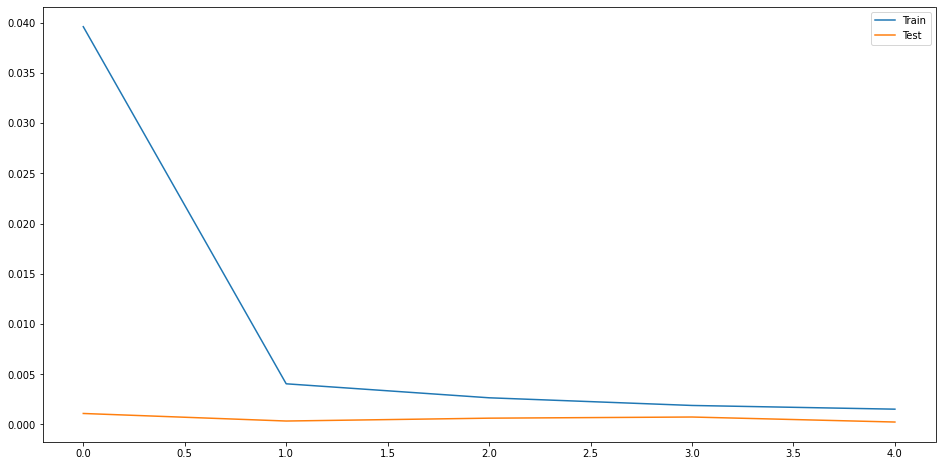

In [78]:
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()

In [89]:
predicted_test = model.predict(x_ts)
predicted_test = test_scaler.inverse_transform(predicted_test.reshape(-1, 1))
actual_test = test_scaler.inverse_transform(y_ts.reshape(-1, 1))

predicted_test = predicted_test.reshape((predicted_test.shape[0],))
actual_test = actual_test.reshape((actual_test.shape[0],))

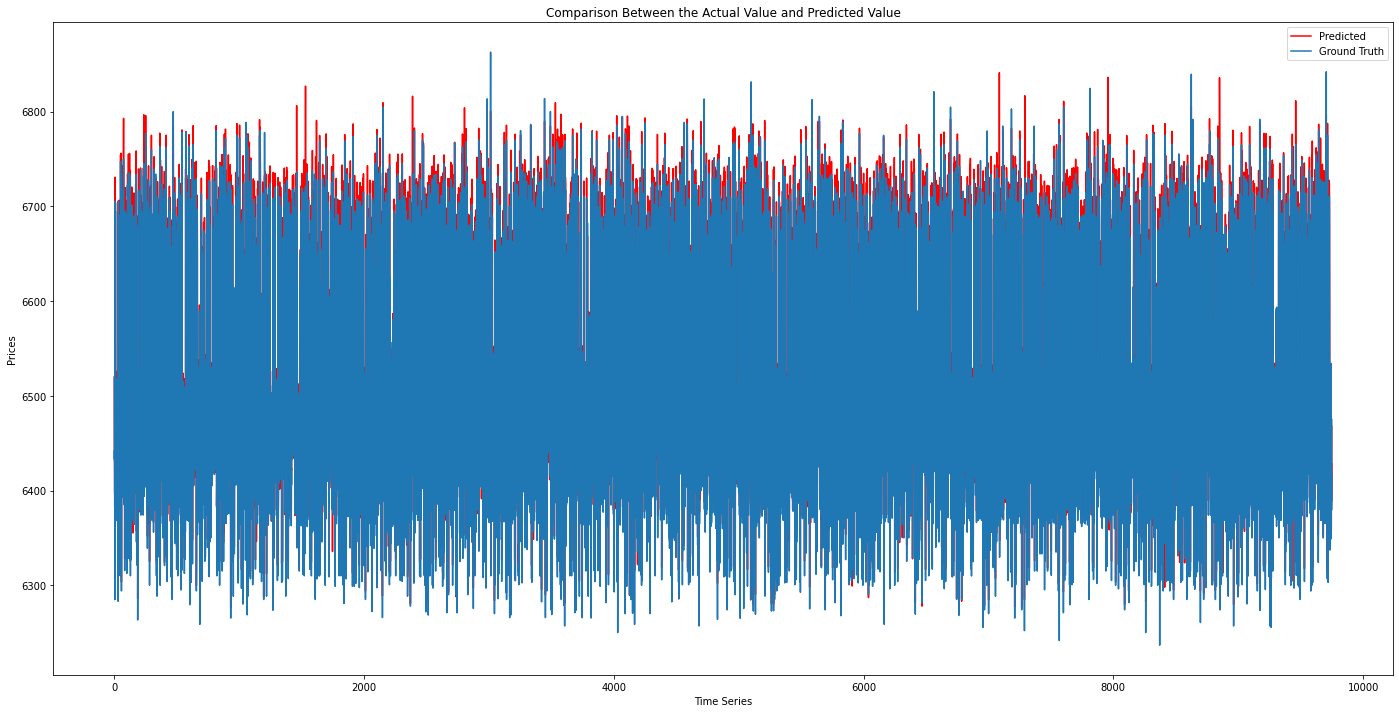

In [100]:
plt.figure(figsize=(24, 12))
plt.plot(predicted_test, 'r', label='Predicted')
plt.plot(actual_test, label='Ground Truth')
plt.title('Comparison Between the Actual Value and Predicted Value')
plt.ylabel('Prices')
plt.xlabel('Time Series')
plt.legend()
plt.show()